In [ ]:
#libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
import librosa
import numpy as np
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
class EmotionAudioDataset(Dataset):
    def __init__(self, root_dirs, sr=16000, max_len=3):
        self.sr = sr
        self.max_len = max_len
        self.files = []

        # RAVDESS mapping
        self.ravdess_emotions = {
            "01": "neutral",
            "02": "calm",
            "03": "happy",
            "04": "sad",
            "05": "angry",
            "06": "fearful",
            "07": "disgust",
            "08": "surprised"
        }

        # CREMA-D mapping
        self.cremad_emotions = {
            "ANG": "angry",
            "DIS": "disgust",
            "FEA": "fearful",
            "HAP": "happy",
            "NEU": "neutral",
            "SAD": "sad"
        }
        # Collect all .wav files
        for root in root_dirs:
            self.files.extend(glob(os.path.join(root, "**", "*.wav"), recursive=True))

        all_emotions = sorted(set(self.ravdess_emotions.values()) | set(self.cremad_emotions.values()))
        self.label2id = {emo: idx for idx, emo in enumerate(all_emotions)}
        self.id2label = {idx: emo for emo, idx in self.label2id.items()}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        fname = os.path.basename(path)

        # Extract emotion label
        if "Actor_" in path:  # RAVDESS
            emo_code = fname.split("-")[2]
            emo = self.ravdess_emotions.get(emo_code, "unknown")
        else:  # CREMA-D
            emo_code = fname.split("_")[2]
            emo = self.cremad_emotions.get(emo_code, "unknown")

        label = self.label2id[emo]

        # Load & preprocess audio
        wav, _ = librosa.load(path, sr=self.sr, mono=True)
        num_samples = self.sr * self.max_len
        wav = wav[:num_samples] if len(wav) > num_samples else np.pad(wav, (0, num_samples - len(wav)))
        wav = torch.tensor(wav, dtype=torch.float32)

        # Mel spectrogram & MFCC
        mel = torchaudio.transforms.MelSpectrogram(sample_rate=self.sr, n_mels=40)(wav)
        mel_db = torchaudio.transforms.AmplitudeToDB()(mel).T
        mfcc = librosa.feature.mfcc(y=wav.numpy(), sr=self.sr, n_mfcc=40).T
        mfcc = librosa.util.fix_length(mfcc, size=mel_db.shape[0], axis=0)

        # Concatenate & normalize
        features = np.concatenate([mel_db.numpy(), mfcc], axis=1)
        features = StandardScaler().fit_transform(features)

        return torch.tensor(features, dtype=torch.float32), label

In [5]:
# Model definition
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=8, num_layers=2, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [6]:
#training configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = EmotionAudioDataset(["./ravdess_data", "./cremad_data/AudioWAV"])
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

sample_x, _ = dataset[0]
input_dim = sample_x.shape[1]
num_classes = len(dataset.label2id)

model = BiLSTMClassifier(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
#training loop
EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/30], Loss: 1.7523
Epoch [2/30], Loss: 1.5994
Epoch [3/30], Loss: 1.5514
Epoch [4/30], Loss: 1.5173
Epoch [5/30], Loss: 1.4818
Epoch [6/30], Loss: 1.4460
Epoch [7/30], Loss: 1.4174
Epoch [8/30], Loss: 1.3843
Epoch [9/30], Loss: 1.3600
Epoch [10/30], Loss: 1.3159
Epoch [11/30], Loss: 1.2793
Epoch [12/30], Loss: 1.2586
Epoch [13/30], Loss: 1.2260
Epoch [14/30], Loss: 1.1776
Epoch [15/30], Loss: 1.1513
Epoch [16/30], Loss: 1.1252
Epoch [17/30], Loss: 1.0795
Epoch [18/30], Loss: 1.0589
Epoch [19/30], Loss: 1.0201
Epoch [20/30], Loss: 0.9797
Epoch [21/30], Loss: 0.9651
Epoch [22/30], Loss: 0.9249
Epoch [23/30], Loss: 0.9018
Epoch [24/30], Loss: 0.8562
Epoch [25/30], Loss: 0.8554
Epoch [26/30], Loss: 0.7999
Epoch [27/30], Loss: 0.7771
Epoch [28/30], Loss: 0.7522
Epoch [29/30], Loss: 0.7329
Epoch [30/30], Loss: 0.6961


In [8]:
#evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        y_true.extend(yb.tolist())
        y_pred.extend(preds.argmax(dim=1).cpu().tolist())

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print(f"\n✅ Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}% | F1: {f1*100:.2f}%")


✅ Accuracy: 48.23%
Precision: 54.18% | Recall: 52.93% | F1: 52.97%


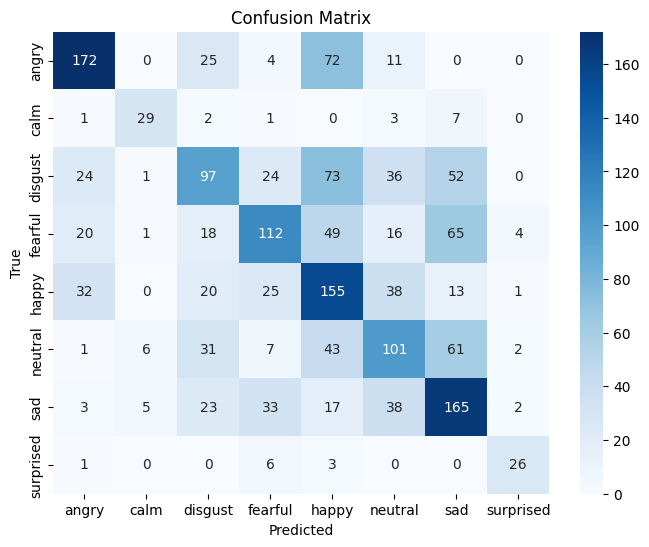

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.id2label.values(),
            yticklabels=dataset.id2label.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [10]:
torch.save(model.state_dict(), "bilstm_emotion_v2.pt")
print("Model saved as bilstm_emotion_v2.pt")

Model saved as bilstm_emotion_v2.pt
